In [1]:
import time
import os
from sqlalchemy import create_engine
from tone_functions import categories, get_tone_data
from numerical_intensity import num_count
from fl_sents import prop_fl_sents

conn_string = 'postgresql://' + os.environ['PGHOST'] + '/' + os.environ['PGDATABASE']
engine = create_engine(conn_string)

input_schema = "streetevents"
input_table = "speaker_data"
output_schema = "streetevents"
output_table = "linguistic_features"

In [2]:
def getFileNames(output_table, output_schema, num_files=None):
    import pandas as pd

    # Using LIMIT is much faster than getting all files and ditching
    # unneeded ones.
    if num_files==None:
        limit_clause = ""
    else:
        limit_clause = "LIMIT %s" % (num_files)

    # Get a list of unprocessed files. Query differs according to whether
    # any files have been processed (i.e., output_table exists)
    conn = engine.connect()
    table_exists = engine.dialect.has_table(conn, output_table, schema=output_schema)
    conn.close()

    if table_exists:
        sql = """
            WITH latest_call AS (
                SELECT file_name, last_update
                FROM streetevents.calls
                WHERE event_type=1)
            SELECT DISTINCT file_name, last_update
            FROM latest_call
            EXCEPT
            SELECT file_name, last_update
            FROM %s.%s
            %s
        """ % (output_schema, output_table, limit_clause)
        files = pd.read_sql(sql, engine)
    else:
        sql = """CREATE TABLE %s.%s
                (
                    file_name text,
                    last_update timestamp with time zone,
                    speaker_name text,
                    employer text,
                    role text,
                    speaker_number integer,
                    context text,
                    language text,
                    positive int,
                    negative int,
                    uncertainty int,
                    litigious int,
                    modal_strong int,
                    modal_weak int,
                    num_count int)
            """ % (output_schema, output_table)
        engine.execute(sql)

        sql = """
            SELECT DISTINCT file_name, last_update
            FROM streetevents.calls
            WHERE event_type=1
            %s
        """ % (limit_clause)
        files = pd.read_sql(sql, engine)

    return files

In [3]:
def processFile(file_name):

    # Get syllable data for the file_name
    speaker_data = getLFData(file_name)
    for cat in categories:
        speaker_data[cat] = speaker_data['speaker_text'].map(lambda x: get_tone_data(x, cat))    
    speaker_data['num_count'] = speaker_data['speaker_text'].map(num_count)
    speaker_data['last_update'] = speaker_data['last_update'].map(lambda x: str(x))
    speaker_data = speaker_data.drop(['speaker_text'], 1)

    # Submit dataframe to database
    conn = engine.connect()
    speaker_data.to_sql(output_table, conn, schema=output_schema, if_exists='append',
              index=False)
    conn.close()

def getLFData(file_name):
    from pandas.io.sql import read_sql
    
    conn = engine.connect()
    table_exists = engine.dialect.has_table(conn, output_table, schema=output_schema)
    conn.close()

    # It may be better to explicitly create the table elsewhere.
    # Checking like this might be slower.
    if table_exists:
        sql = "DELETE FROM %s.%s WHERE file_name='%s'" % \
            (output_schema, output_table, file_name)

        engine.execute(sql)

    sql = """
        SELECT file_name, last_update, speaker_name, employer, role, 
            speaker_number, context, speaker_text
        FROM %s.%s
        WHERE file_name='%s'
        """ % (input_schema, input_table, file_name)

    df = read_sql(sql, engine)

    return df

In [4]:
import numpy as np
import matplotlib.pyplot as plt
diff = np.empty(10)
for i in np.arange(10):
    start = time.time()
    files = getFileNames(output_table, output_schema, 10000*(i+1))
    end = time.time()
    diff[i] = end - start
diff

array([ 0.72072744,  0.5936358 ,  0.70203853,  0.71723819,  0.82485366,
        0.84979701,  0.9476831 ,  0.96957803,  1.05472207,  1.09763455])

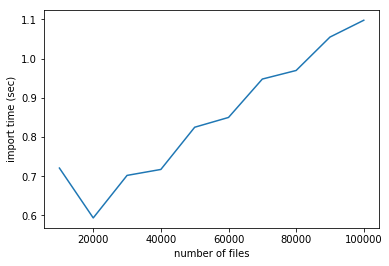

In [5]:
plt.plot(10000*(np.arange(10) + 1), diff)
plt.ylabel('import time (sec)')
plt.xlabel('number of files')
plt.show()

In [6]:
files = getFileNames(output_table, output_schema, 1000)

In [7]:
def timeProcessFile(file):
    start = time.time()
    processFile(file)
    end = time.time()
    return end - start 

In [8]:
time_process = [timeProcessFile(file) for file in files['file_name']]

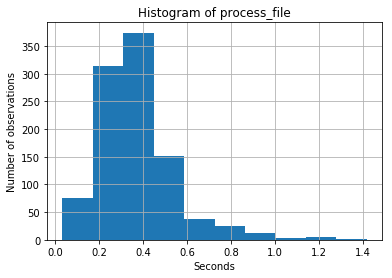

In [9]:
n, bins, patches = plt.hist(time_process)
plt.xlabel('Seconds')
plt.ylabel('Number of observations')
plt.title('Histogram of process_file')
plt.grid(True)
plt.show()